In [2]:
import numpy as np
import torch 
from torch.utils.data import Dataset , DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , accuracy_score
import cv2
import random
import sys

### In Python's OpenCV library (cv2), the imread function is used to read an image from a file and load it into memory as a NumPy array. This array can be used for image processing, analysis, and computer vision tasks.


In [4]:
tumor=[]
health=[]
for f in glob.iglob('./data/dataset/yes/*.jpg'):
    img=cv2.imread(f)
    img=cv2.resize(img , (128 , 128))
    b , g, r=cv2.split(img)
    img=cv2.merge([r, g, b])
    tumor.append(img)
for f in glob.iglob('./data/dataset/no/*.jpg'):
    img=cv2.imread(f)
    img=cv2.resize(img , (128 , 128))
    b , g, r=cv2.split(img)
    img=cv2.merge([r, g, b])
    health.append(img)

In [12]:
health=np.array(health)
tumor=np.array(tumor)
All=np.concatenate((health, tumor))

In [17]:
health.shape

(1218, 128, 128, 3)

In [18]:
tumor.shape

(704, 128, 128, 3)

Visuliaze brain mri images

In [20]:
def plot_random(healthy, tumor , num=6):
    health_images=healthy[np.random.choice(healthy.shape[0] , num , replace=False)]
    tumor_images=tumor[np.random.choice(tumor.shape[0] , num , replace=False)]
    plt.figure(figsize=(16 , 9))

    for i in range(num):
        plt.subplot(1 , num , i+1)
        plt.title('Health images')
        plt.imshow(health_images[i])
    plt.figure(figsize=(16 , 9))
    for i in range(num):
        plt.subplot(1 , num , i+1)
        plt.title('Tumor images')
        plt.imshow(tumor_images[i])

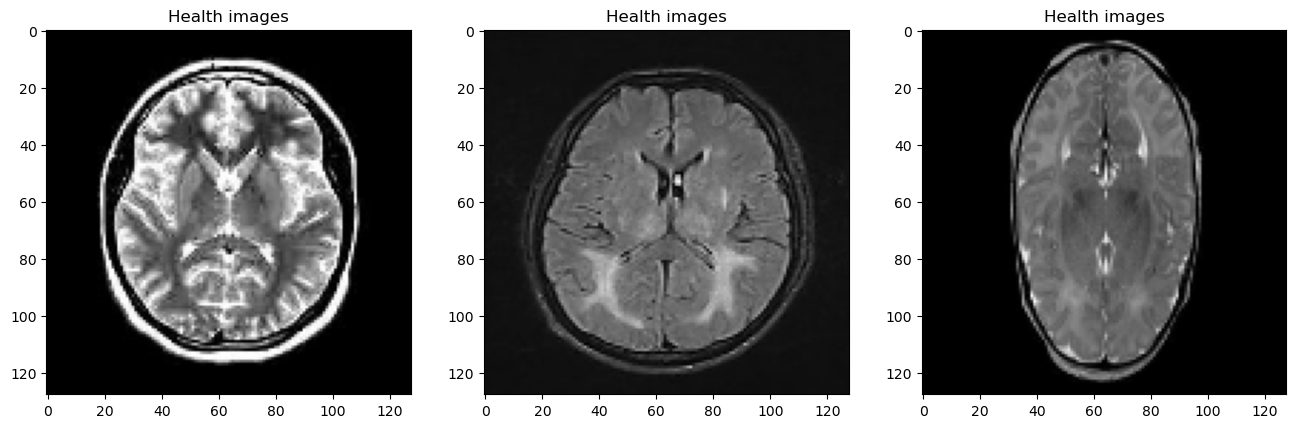

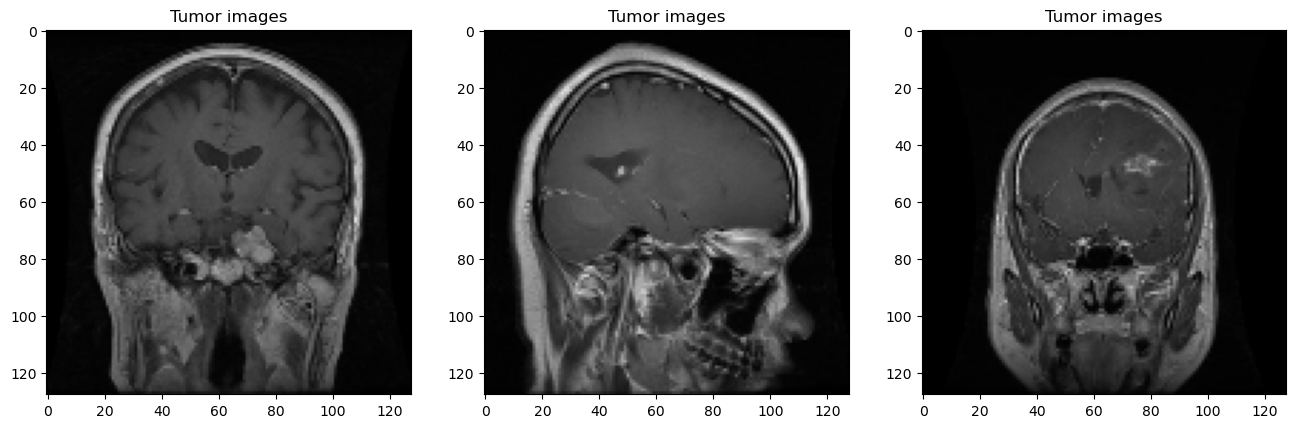

In [21]:
plot_random(health , tumor, 3)

In [22]:
class Dataset(object):
    def __getitem__(self , index):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError

    def __add__(self , other):
        return ConcatDataset([self , other])
        

Creating MRI DATA CLASS CUSTOM CLASS FUCK IT 

In [39]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [40]:
mri_dataset = MRI()
mri_dataset.normalize()

torch.Size([3, 128, 128])
torch.Size([128, 128, 3])


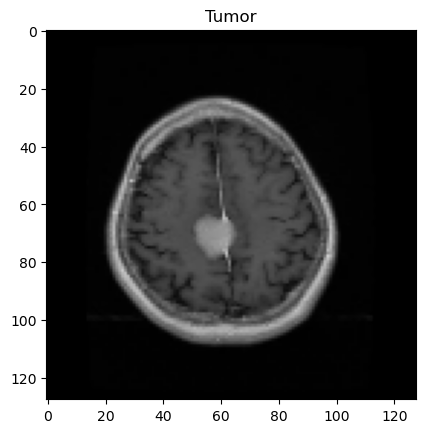

torch.Size([3, 128, 128])
torch.Size([128, 128, 3])


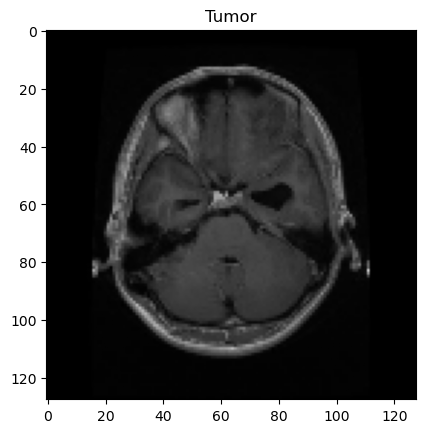

torch.Size([3, 128, 128])
torch.Size([128, 128, 3])


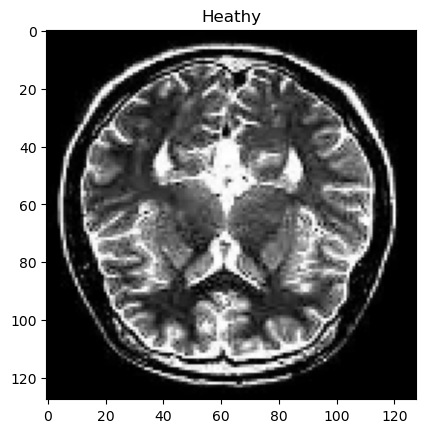

torch.Size([3, 128, 128])
torch.Size([128, 128, 3])


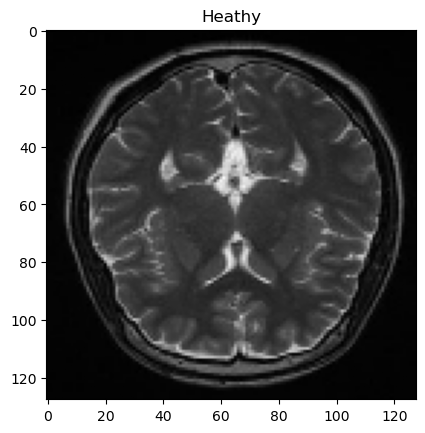

torch.Size([3, 128, 128])
torch.Size([128, 128, 3])


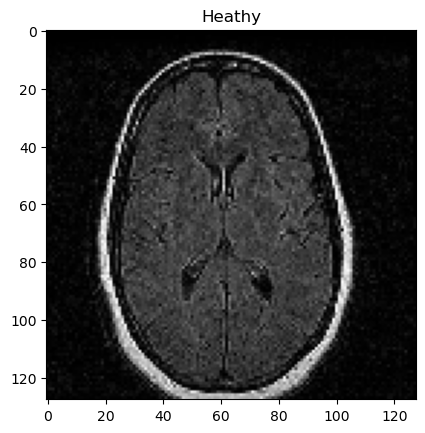

torch.Size([3, 128, 128])
torch.Size([128, 128, 3])


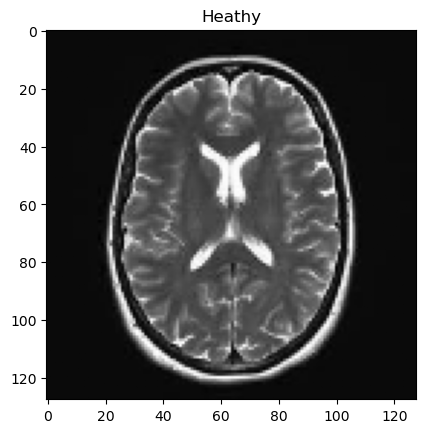

In [43]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    print(img.shape)
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    print(img.shape)
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.5403, 0.6351, 0.3510, 0.7566, 0.7844, 0.0597, 0.3609, 0.7266, 0.6080,
        0.1323], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.5403, 0.6351, 0.3510, 0.7566, 0.7844, 0.0597, 0.3609, 0.7266, 0.6080,
        0.1323], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.2919, 0.4034, 0.1232, 0.5724, 0.6152, 0.0036, 0.1303, 0.5280, 0.3697,
        0.0175], device='cuda:0')


In [46]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0')
model = CNN().to(device)

In [47]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [48]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    

In [49]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [50]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [51]:

accuracy_score(y_true, threshold(outputs))

0.39125910509885536

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

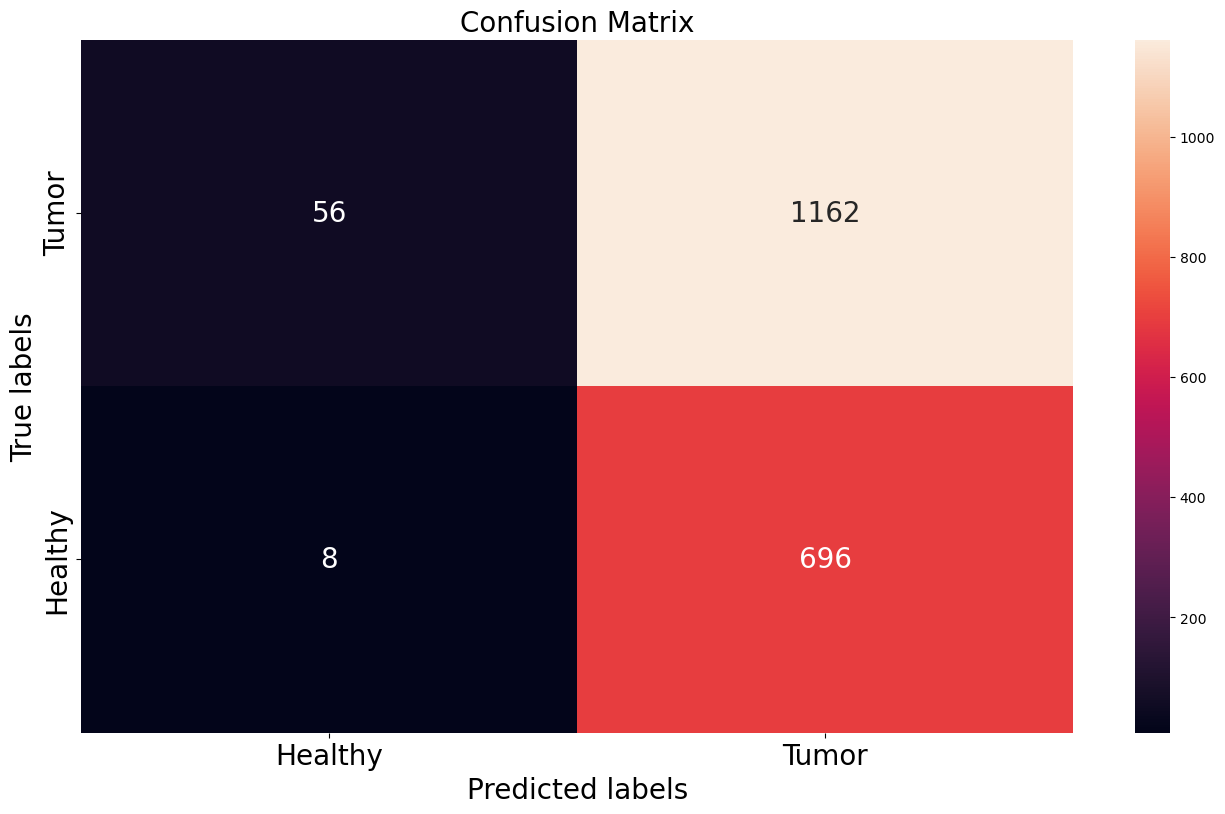

In [52]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

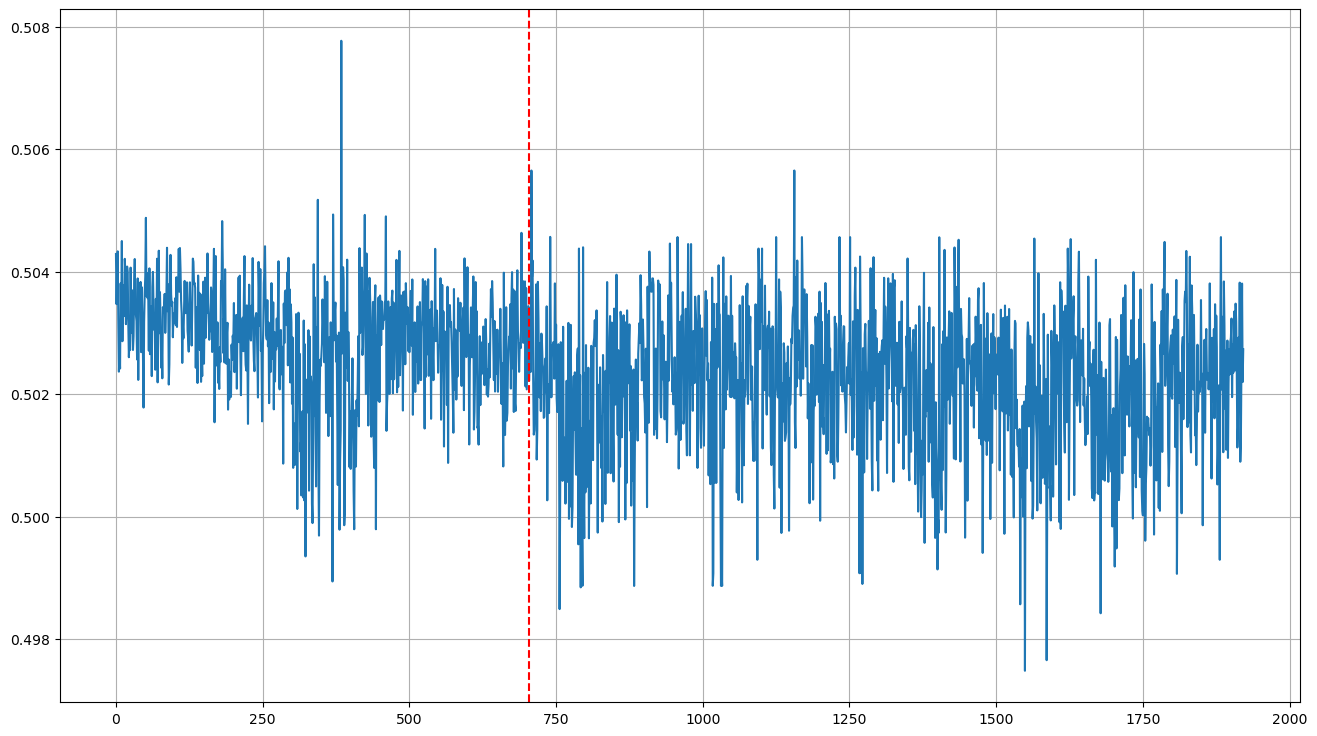

In [53]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [54]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [55]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.492507
Train Epoch: 20	Loss: 0.414300
Train Epoch: 30	Loss: 0.361083
Train Epoch: 40	Loss: 0.340660
Train Epoch: 50	Loss: 0.315753
Train Epoch: 60	Loss: 0.286258
Train Epoch: 70	Loss: 0.271827
Train Epoch: 80	Loss: 0.250244
Train Epoch: 90	Loss: 0.246550
Train Epoch: 100	Loss: 0.225643
Train Epoch: 110	Loss: 0.202850
Train Epoch: 120	Loss: 0.216796
Train Epoch: 130	Loss: 0.182847
Train Epoch: 140	Loss: 0.169541
Train Epoch: 150	Loss: 0.159021
Train Epoch: 160	Loss: 0.148460
Train Epoch: 170	Loss: 0.137762
Train Epoch: 180	Loss: 0.130090
Train Epoch: 190	Loss: 0.119895
Train Epoch: 200	Loss: 0.109528
Train Epoch: 210	Loss: 0.103149
Train Epoch: 220	Loss: 0.095740
Train Epoch: 230	Loss: 0.086499
Train Epoch: 240	Loss: 0.080585
Train Epoch: 250	Loss: 0.063532
Train Epoch: 260	Loss: 0.055598
Train Epoch: 270	Loss: 0.046660
Train Epoch: 280	Loss: 0.037678
Train Epoch: 290	Loss: 0.034399
Train Epoch: 300	Loss: 0.020090
Train Epoch: 310	Loss: 0.016668
Train Epoch: 320	

In [56]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [57]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

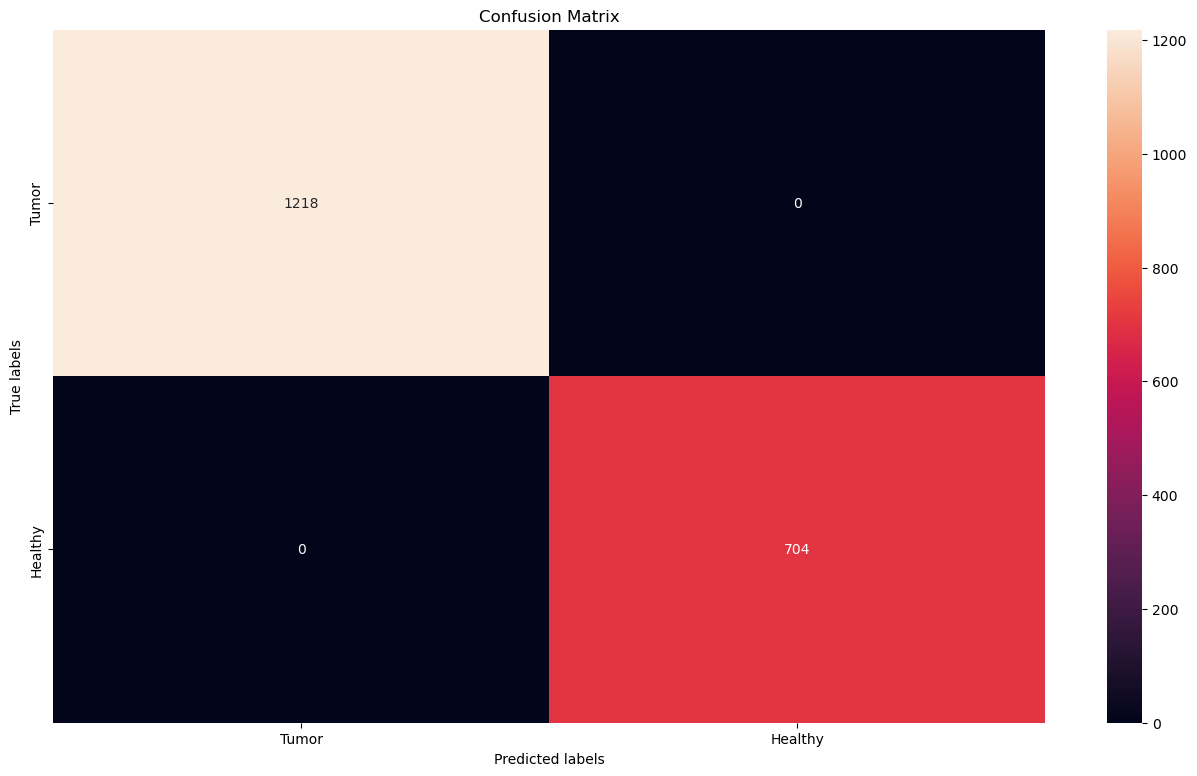

In [58]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])